# Class of Bayesian Classifiers

In [1]:
import pandas as pd
import numpy as np

import pickle
import time
from tqdm import tqdm

# surpess warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Data from Bancolombia, no null values
bancolombia = pd.read_csv('data/bancolombia.csv')
bancolombia.head(1)

,url,news,Type
0,https://www.larepublica.co/redirect/post/3201905,Durante el foro La banca articulador empresari...,Otra


In [3]:
# we will import CountVectorizer to vectorize our text
from sklearn.feature_extraction.text import CountVectorizer

# we will import train_test_split to split our data
from sklearn.model_selection import train_test_split

# load stopwords
with open('stopwords/spanish', 'rb') as f:
    spanish_stopwords = pickle.load(f)
    
vectorizer = CountVectorizer(min_df=5, stop_words=spanish_stopwords)
X = vectorizer.fit_transform(bancolombia['news'])

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, bancolombia['Type'], test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((973, 7661), (244, 7661), (973,), (244,))

In [4]:
# We will import SKLearn NB for comparison
from sklearn.naive_bayes import MultinomialNB

# has laplace smoothing of alpha = 1
sk_nb = MultinomialNB()

start = time.time()
sk_nb.fit(X_train, y_train)
end = time.time()
print(f'SKLearn MultinomialNB')
print(f'Training time:\t\t {end - start:.3f} seconds')
print(f'Training data accuracy:\t {sk_nb.score(X_train, y_train):.3f}')
print(f'Test data accuracy:\t {sk_nb.score(X_test, y_test):.3f}')

SKLearn MultinomialNB
Training time:		 0.008 seconds
Training data accuracy:	 0.952
Test data accuracy:	 0.865


In [5]:
X_train.shape, y_train.shape

((973, 7661), (973,))

In [6]:
def label2num(label):
    classes = np.unique(label)
    num = np.zeros(len(label))
    for i, c in enumerate(classes):
        # print(f'Class {c} is {i}th in num')
        num[label == c] = i

    return num


def label2onehot(label):
    classes = np.unique(label)
    onehot = np.zeros((len(label), len(classes)))
    for i, c in enumerate(classes):
        # print(f'Class {c} is {i}th in onehot')
        onehot[label == c, i] = 1

    onehot
    return onehot


y_train_onehot = label2onehot(y_train)
y_num = label2num(y_train)
y_train_onehot.shape, sum(y_num != np.argmax(y_train_onehot, axis=1))

((973, 7), 0)

In [7]:
prior = y_train_onehot.sum(axis=0) / y_train_onehot.sum()
prior.shape, prior.sum(), prior

((7,),
 1.0,
 array([0.2004111 , 0.16649538, 0.27440904, 0.10380267, 0.12127441,
        0.01747174, 0.11613566]))

In [8]:
X_train.shape, y_train_onehot.shape

((973, 7661), (973, 7))

In [9]:
# numpy display options 7 
np.set_printoptions(precision=10, suppress=True, threshold=7)

alpha = 1
counts = X_train.T.dot(y_train_onehot) + alpha
phi = counts / counts.sum(axis=0)

In [12]:
# create a matrix of nans [sample size, number of classes]
posterior = np.zeros((X_train.shape[0], phi.shape[1]))

for i in tqdm(range(X_train.shape[0])):
    idx = X_train[i,:].nonzero()[1]

    probs = np.power(
        phi[idx, :],
        X_train[i, idx].toarray().T
        )

    probs = probs / np.mean(probs)

    while np.isclose(probs.prod(axis=0), 0).all():
        probs = probs * 2

    posterior[i, :] = probs.prod(axis=0) * prior

predicted = np.argmax(posterior, axis=1)
np.mean(predicted == label2num(y_train))

100%|██████████| 973/973 [00:00<00:00, 1016.96it/s]


0.9516957862281603

In [13]:
np.isinf(posterior).sum(), np.isnan(posterior).sum(), np.isclose(posterior, 0).sum()

(0, 0, 5490)

In [14]:
posterior_test = np.zeros((X_test.shape[0], phi.shape[1]))

for i in tqdm(range(X_test.shape[0])):
    idx = X_test[i,:].nonzero()[1]

    probs = np.power(
        phi[idx, :],
        X_test[i, idx].toarray().T
        )

    probs = probs / np.mean(probs)

    while np.isclose(probs.prod(axis=0), 0).all():
        probs = probs * 2

    posterior_test[i, :] = probs.prod(axis=0) * prior

predicted_test = np.argmax(posterior_test, axis=1)
np.mean(predicted_test == label2num(y_test))

100%|██████████| 244/244 [00:00<00:00, 822.60it/s]


0.8647540983606558

In [39]:
# Now we will implement L1 regularization

def log_likelihood(X, y_onehot, phi, l2):
    """
    X: sparse matrix of shape (n_samples, n_features)
    y: array of shape (n_samples,)
    phi: array of shape (n_features, n_classes)
    prior: array of shape (n_classes,)
    alpha: float
    l2: L2 regularization parameter
    """

    log_l = (X.dot(np.log(phi))[y_onehot.astype(bool)].sum() - l2 * np.power(phi, 2).sum()) / X.shape[0]

    return log_l

def update_phi(X, y, phi, alpha, l2):
    """
    X: sparse matrix of shape (n_samples, n_features)
    y: array of shape (n_samples,)
    phi: array of shape (n_features, n_classes)
    prior: array of shape (n_classes,)
    alpha: float
    l1: L1 regularization parameter
    """

    gradient = np.zeros(phi.shape)

    for i in range(phi.shape[1]):
        gradient[:,i] = X[y[:,i].astype(bool),:].sum(axis=0) / phi[:,i] - 2 * l2 * phi[:,i]

    gradient[gradient < 0] = 0

    phi = phi + alpha * gradient
    phi = phi / phi.sum(axis=0)
    
    return phi

def gradient_ascent(X, y, phi, alpha, l2, max_iter=100, tol=1e-4):
    """
    X: sparse matrix of shape (n_samples, n_features)
    y: array of shape (n_samples,)
    phi: array of shape (n_features, n_classes)
    prior: array of shape (n_classes,)
    alpha: float
    l1: L1 regularization parameter
    max_iter: int
    tol: float
    """

    log_likelihoods = []
    for i in tqdm(range(max_iter)):
        phi = update_phi(X, y, phi, alpha, l2)
        log_l = log_likelihood(X, y, phi, l2)
        log_likelihoods.append(log_l)

        if i > 0 and np.abs(log_l - log_likelihoods[-2]) < tol:
            break

    return phi, log_likelihoods

100%|██████████| 100/100 [00:01<00:00, 96.03it/s] 


<AxesSubplot:>

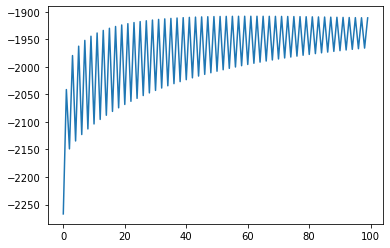

In [40]:
phi0 = phi.copy()
l2 = 1000
alpha = 0.000001

phi0 = np.random.rand(phi0.shape[0], phi0.shape[1])

phi_l2, log_likelihoods = gradient_ascent(X_train, y_train_onehot, phi0, alpha, l2)

# plot the log likelihoods
pd.Series(log_likelihoods).plot()

In [41]:
log_posterior = np.log(prior) + X_train.dot(np.log(phi))
log_predicted = np.argmax(log_posterior, axis=1)

log_posterior_l2 = np.log(prior) + X_train.dot(np.log(phi_l2))
log_predicted_l2 = np.argmax(log_posterior_l2, axis=1)


np.mean(log_predicted_l2 == label2num(y_train)), np.mean(log_predicted == label2num(y_train))

(0.9969167523124358, 0.9516957862281603)

In [28]:
log_posterior = np.log(prior) + X_test.dot(np.log(phi))
log_predicted = np.argmax(log_posterior, axis=1)

log_posterior_l2 = np.log(prior) + X_test.dot(np.log(phi_l2))
log_predicted_l2 = np.argmax(log_posterior_l2, axis=1)

np.mean(log_predicted_l2 == label2num(y_test)), np.mean(log_predicted == label2num(y_test))

(0.7663934426229508, 0.8647540983606558)

In [29]:
my_nbc = nbc.ClassicalNaiveBayes()

NameError: name 'nbc' is not defined

In [30]:
import nbc
cnbc = nbc.ClassicalNaiveBayes(alpha=1)

cnbc.fit(X_train, y_train)
cnbc.score(X_train, y_train), cnbc.score(X_test, y_test)

100%|██████████| 244/244 [00:00<00:00, 545.70it/s]


(0.9516957862281603, 0.8647540983606558)

In [32]:
cnbc.fit_weighted(X_train, y_train)

cnbc.score(X_train, y_train), cnbc.score(X_test, y_test)

100%|██████████| 244/244 [00:00<00:00, 677.80it/s]


(0.9506680369989723, 0.8647540983606558)

In [33]:
cnbc.fit_L2(X_train, y_train)

cnbc.score(X_train, y_train), cnbc.score(X_test, y_test)

TypeError: gradient_ascent() missing 1 required positional argument: 'l2'